# Morphology of M51

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from astropy.io import fits
from astropy.visualization import ZScaleInterval

# open target image

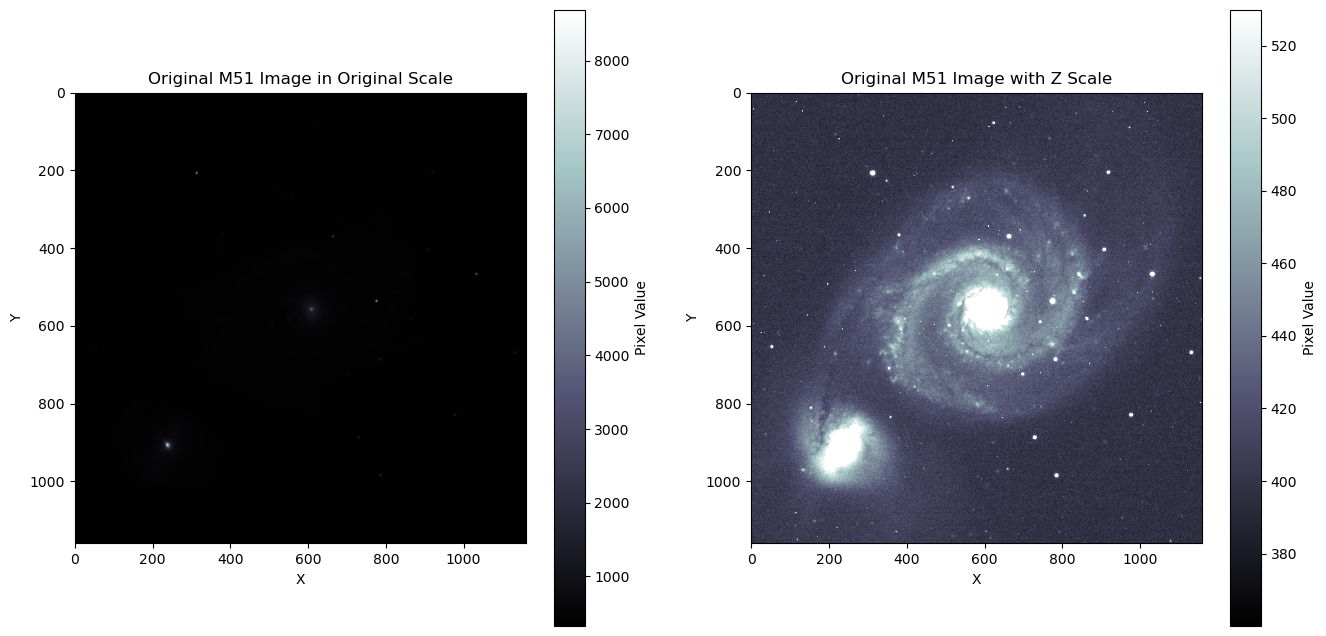

In [2]:
# fits 파일 경로
fits_file_path = r"C:/Users/User/AO1_JaehwanShin/00-preprocessing/My_Data/M51-0001i_new-image.fits"

# fits 파일 열기
with fits.open(fits_file_path) as hdul:
    # 이미지 데이터 가져오기
    image_data = hdul[0].data

# Z 스케일로 이미지의 최소 및 최대값 계산
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(image_data)

# 결과 이미지 표시
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 원래 스케일로 결과 이미지 표시
axes[0].imshow(image_data, cmap='bone')
axes[0].set_title('Original M51 Image in Original Scale')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].figure.colorbar(axes[0].images[0], ax=axes[0], label='Pixel Value')

# Z 스케일로 결과 이미지 표시
axes[1].imshow(image_data, cmap='bone', vmin=vmin, vmax=vmax)
axes[1].set_title('Original M51 Image with Z Scale')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].figure.colorbar(axes[1].images[0], ax=axes[1], label='Pixel Value')

plt.show()

# Image reconstruction
### "Since M51 is inclined about 20 degrees from our line of sight,  
### using orthogonal projection will make it appear face-on."

## 1. rotating image

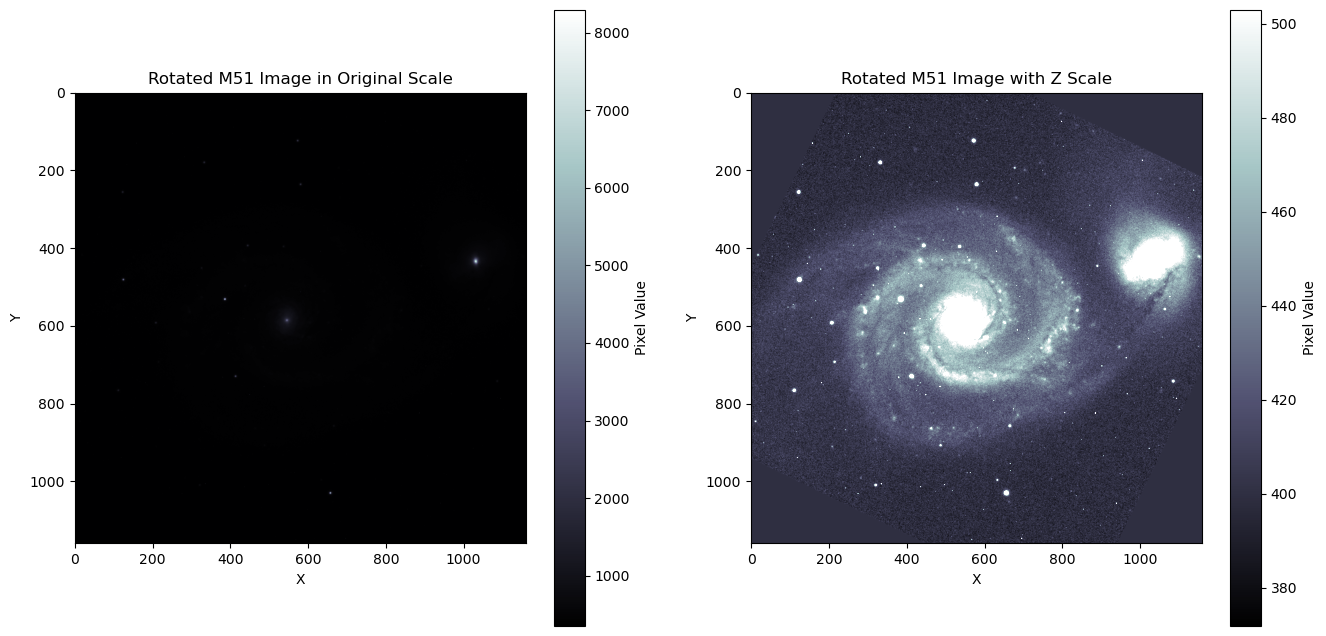

In [3]:
from scipy.ndimage import rotate
from astropy.visualization import ZScaleInterval

# 사용자가 입력한 좌표
xc, yc = 612, 560  # 회전축이되는 픽셀 (은하의 중심)

# 회전 각도
angle = 154  # 회전 각도 (단위: 도)

# 이미지를 중심으로 회전
rotated_image = rotate(image_data, angle, reshape=False, order=1, mode='constant', cval=400.0, prefilter=True)

# Z 스케일로 이미지의 최소 및 최대값 계산
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(rotated_image)

# 결과 이미지 표시
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 원래 스케일로 결과 이미지 표시
axes[0].imshow(rotated_image, cmap='bone')
axes[0].set_title('Rotated M51 Image in Original Scale')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].figure.colorbar(axes[0].images[0], ax=axes[0], label='Pixel Value')

# Z 스케일로 결과 이미지 표시
axes[1].imshow(rotated_image, cmap='bone', vmin=vmin, vmax=vmax)
axes[1].set_title('Rotated M51 Image with Z Scale')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].figure.colorbar(axes[1].images[0], ax=axes[1], label='Pixel Value')

plt.show()


## 2. Orthogonal projection: y-axis value divided by cos(20°).

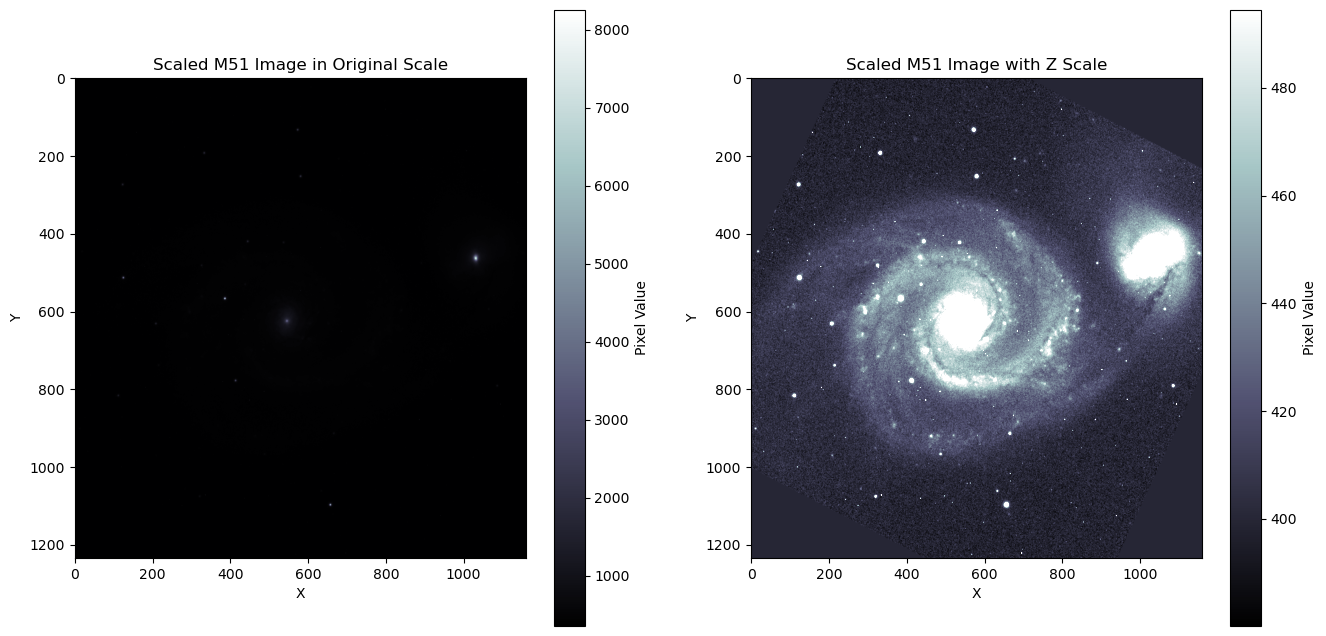

In [4]:
# 각도에 대한 삼각함수 값 계산 (20도)
cos_angle_20 = np.cos(np.deg2rad(20))

# 이미지의 높이를 삼각함수 값으로 나누어 조정
scaled_height = int(rotated_image.shape[0] / cos_angle_20)

# 이미지 크기 조정 (이전 높이를 기준으로 새로운 높이를 설정)
scaled_image = np.full((scaled_height, rotated_image.shape[1]), 7700.0)  # 초기값을 7700으로 설정
for i in range(rotated_image.shape[1]):
    scaled_image[:, i] = np.interp(np.linspace(0, rotated_image.shape[0] - 1, scaled_height),
                                   np.arange(rotated_image.shape[0]), rotated_image[:, i])

# Z 스케일로 이미지의 최소 및 최대값 계산 (스케일링된 이미지에 대해)
vmin_scaled, vmax_scaled = zscale.get_limits(scaled_image)

# 결과 이미지 표시
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 원래 스케일로 결과 이미지 표시 (스케일링된 이미지)
axes[0].imshow(scaled_image, cmap='bone')
axes[0].set_title('Scaled M51 Image in Original Scale')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].figure.colorbar(axes[0].images[0], ax=axes[0], label='Pixel Value')

# Z 스케일로 결과 이미지 표시 (스케일링된 이미지)
axes[1].imshow(scaled_image, cmap='bone', vmin=vmin_scaled, vmax=vmax_scaled)
axes[1].set_title('Scaled M51 Image with Z Scale')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].figure.colorbar(axes[1].images[0], ax=axes[1], label='Pixel Value')

plt.show()


# Image binning (for high pixel count)

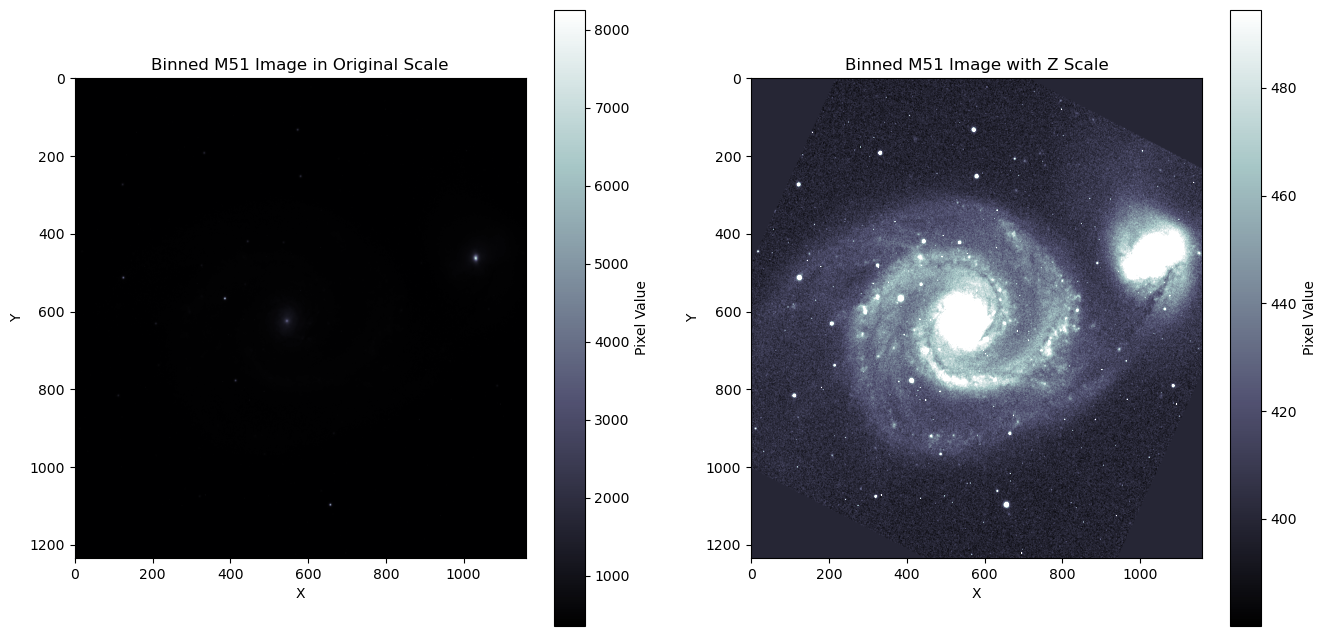

In [5]:
def bin_image(image, binning_factor):
    """
    이미지 데이터를 바이닝합니다.
    :param image: 2D numpy array, 바이닝할 이미지
    :param binning_factor: int, 바이닝 팩터 (예: 2x2 바이닝은 2)
    :return: 2D numpy array, 바이닝된 이미지
    """
    shape = (image.shape[0] // binning_factor, binning_factor,
             image.shape[1] // binning_factor, binning_factor)
    binned_image = image[:shape[0] * binning_factor, :shape[2] * binning_factor].reshape(shape).mean(axis=(1, 3))
    return binned_image

# 바이닝 팩터 설정
binning_factor = 1

# 이미지를 바이닝
binned_image = bin_image(scaled_image, binning_factor)

# Z 스케일로 이미지의 최소 및 최대값 계산
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(binned_image)

# 결과 이미지 표시
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 원래 스케일로 결과 이미지 표시 (바이닝된 이미지)
axes[0].imshow(binned_image, cmap='bone')
axes[0].set_title('Binned M51 Image in Original Scale')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].figure.colorbar(axes[0].images[0], ax=axes[0], label='Pixel Value')

# Z 스케일로 결과 이미지 표시 (바이닝된 이미지)
axes[1].imshow(binned_image, cmap='bone', vmin=vmin, vmax=vmax)
axes[1].set_title('Binned M51 Image with Z Scale')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].figure.colorbar(axes[1].images[0], ax=axes[1], label='Pixel Value')

plt.show()


# Fit a logarithmic spiral from the center.

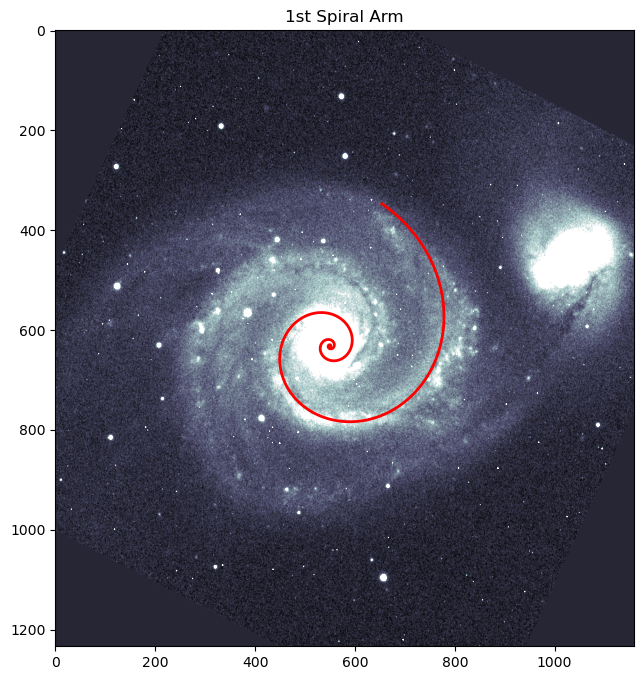

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 로그 나선 방정식의 파라미터
a1 = 1.5
b1 = 0.26  # 나선의 팽창 속도
num_points1 = 1000  # 나선의 포인트 수
theta1 = np.linspace(0, 6.5 * np.pi, num_points1)  # 0에서 6.5파이까지의 각도
r1 = a1 * np.exp(b1 * theta1)

# 나선의 x, y 좌표 계산
x1 = r1 * np.cos(theta1)
y1 = r1 * np.sin(theta1)

# 사용자에게 중앙 좌표 입력 받기
center_x1 = 550
center_y1 = 632

# 나선을 이미지에 맞게 중앙으로 이동
x1 += center_x1
y1 += center_y1

# x 좌표 반전 (x 축 대칭)
x1 = 2 * center_x1 - x1

# 회전 각도 (라디안 단위로 설정, 여기서는 200도 반시계방향 회전)

angle1 = np.deg2rad(200)

# 회전 행렬 정의
rotation_matrix1 = np.array([[np.cos(angle1), -np.sin(angle1)], 
                            [np.sin(angle1), np.cos(angle1)]])

# 좌표 변환
coords1 = np.vstack((x1 - center_x1, y1 - center_y1))
rotated_coords1 = rotation_matrix1 @ coords1
x_rotated1 = rotated_coords1[0, :] + center_x1
y_rotated1 = rotated_coords1[1, :] + center_y1

# 결과 이미지 표시 (나선만)
plt.figure(figsize=(8, 8))
plt.imshow(scaled_image, cmap='bone', vmin=vmin, vmax=vmax)
plt.plot(x_rotated1, y_rotated1, color='red', linewidth=2) # 회전된 나선 그리기
plt.title('1st Spiral Arm')
plt.show()


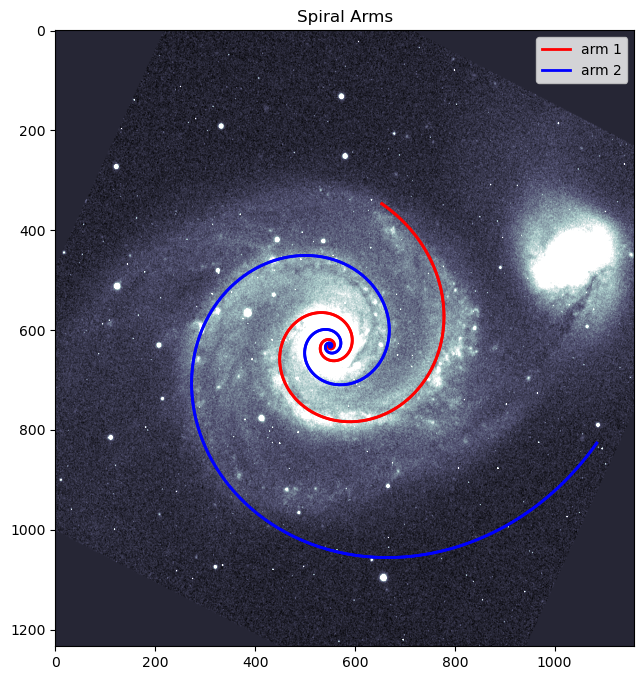

In [7]:
# 두 번째 로그 나선 방정식의 파라미터
# a2 = 1.5
a2 = 1.5  # 나선의 초기 반경
b2 = 0.27  # 나선의 팽창 속도
num_points2 = 1000  # 나선의 포인트 수
theta2 = np.linspace(0, 7 * np.pi, num_points2)  # 0에서 7파이까지의 각도
r2 = a2 * np.exp(b2 * theta2)

# 두 번째 나선의 x, y 좌표 계산
x2 = r2 * np.cos(theta2)
y2 = r2 * np.sin(theta2)

# 두 번째 나선을 이미지에 맞게 중앙으로 이동
center_x2 = 550
center_y2 = 632
x2 += center_x2
y2 += center_y2

# x 좌표 반전 (x 축 대칭)
x2 = 2 * center_x2 - x2

# 회전 각도 (라디안 단위로 설정, 여기서는 30도 반시계방향 회전)

angle2 = np.deg2rad(20)
# 회전 행렬 정의
rotation_matrix2 = np.array([[np.cos(angle2), -np.sin(angle2)], 
                            [np.sin(angle2), np.cos(angle2)]])

# 좌표 변환
coords2 = np.vstack((x2 - center_x2, y2 - center_y2))
rotated_coords2 = rotation_matrix2 @ coords2
x_rotated2 = rotated_coords2[0, :] + center_x2
y_rotated2 = rotated_coords2[1, :] + center_y2

# 결과 이미지 표시 (나선만)
plt.figure(figsize=(8, 8))
plt.imshow(scaled_image, cmap='bone', vmin=vmin, vmax=vmax)
plt.plot(x_rotated1, y_rotated1, color='red', linewidth=2)  # 첫 번째 회전된 나선 그리기
plt.plot(x_rotated2, y_rotated2, color='blue', linewidth=2)  # 두 번째 회전된 나선 그리기
plt.plot(x_rotated1, y_rotated1, color='red', linewidth=2, label='arm 1')  # 첫 번째 회전된 나선 그리기
plt.plot(x_rotated2, y_rotated2, color='blue', linewidth=2, label='arm 2')  # 두 번째 회전된 나선 그리기
plt.legend()
plt.title('Spiral Arms')
plt.show()


# Drawing ellipses from the center of the galaxy, then extracting pixels with the top 3% pixel values along the elliptical arc. Here, two half-ellipses were used for better fitting.

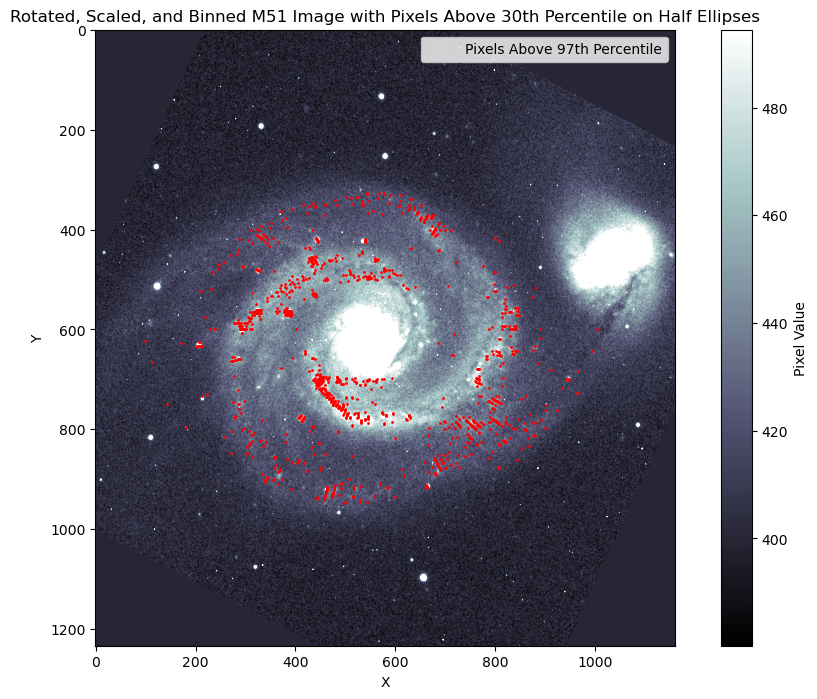

In [8]:
    # Z 스케일로 이미지의 최소 및 최대값 계산
    zscale = ZScaleInterval()
    vmin, vmax = zscale.get_limits(binned_image)

    # 중심 좌표를 바이닝 팩터로 나누어 조정
    xc_binned1, yc_binned1 = 550 // binning_factor, 600 // binning_factor

    # 반타원의 각도 설정
    theta_half1 = np.linspace(0, np.pi, 100)

    # 결과 이미지 표시
    plt.figure(figsize=(12, 8))
    plt.imshow(binned_image, cmap='bone', vmin=vmin, vmax=vmax)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.colorbar(label='Pixel Value')
    plt.title('Rotated, Scaled, and Binned M51 Image with Pixels Above 30th Percentile on Half Ellipses')

    # 반지름 범위 설정
    radius_ranges1 = [(100, 125), (125, 150), (150, 175), (175, 200), (200, 225), (225, 250), (250, 275), (275, 300), (300, 325), (325, 350)]

    for radius_range1 in radius_ranges1:
        min_radius1, max_radius1 = radius_range1
        radii1 = np.arange(min_radius1, max_radius1, 1)

        for radius1 in radii1:
            a = radius1 * 1.3  # 타원의 가로 반지름
            b = radius1  # 타원의 세로 반지름

            # 중심 좌표를 기준으로 반타원 위의 좌표 생성
            x_ellipse1 = xc_binned1 + a * np.cos(theta_half1)
            y_ellipse1 = yc_binned1 + b * np.sin(theta_half1)

            pixel_values1 = binned_image[np.round(y_ellipse1).astype(int), np.round(x_ellipse1).astype(int)]

            # 반타원 위의 픽셀 값 97번째 백분위수 계산
            percentile_301 = np.percentile(pixel_values1, 97)

            # 30번째 백분위수보다 큰 픽셀 좌표 선택
            above_30th_percentile1 = pixel_values1 > percentile_301
            x_above_301 = x_ellipse1[above_30th_percentile1]
            y_above_301 = y_ellipse1[above_30th_percentile1]

            # 반타원과 30번째 백분위수보다 큰 픽셀 표시
            plt.plot(x_ellipse1, y_ellipse1, 'b--', alpha=0)  # 반타원 표시
            plt.plot(x_above_301, y_above_301, 'ro', markersize=1)  # 30번째 백분위수보다 큰 픽셀 좌표 표시

    # Second set of data

    # 중심 좌표를 바이닝 팩터로 나누어 조정
    xc_binned, yc_binned = 550 // binning_factor, 600 // binning_factor

    # 반타원의 각도 설정
    theta_half = np.linspace(np.pi, 2 * np.pi, 100)

    # 반지름 범위 설정
    radius_ranges = [(100, 125), (125, 150), (150, 175), (175, 200), (200, 225), (225, 250), (250, 275), ]

    for radius_range in radius_ranges:
        min_radius, max_radius = radius_range
        radii = np.arange(min_radius, max_radius, 1)

        for radius in radii:
            a = radius *  1.3 # 타원의 가로 반지름
            b = radius  # 타원의 세로 반지름

            # 중심 좌표를 기준으로 반타원 위의 좌표 생성
            x_ellipse = xc_binned + a * np.cos(theta_half)
            y_ellipse = yc_binned + b * np.sin(theta_half)

            pixel_values = binned_image[np.round(y_ellipse).astype(int), np.round(x_ellipse).astype(int)]

            # 반타원 위의 픽셀 값 97번째 백분위수 계산
            percentile_30 = np.percentile(pixel_values, 97)

            # 97번째 백분위수보다 큰 픽셀 좌표 선택
            above_30th_percentile = pixel_values > percentile_30
            x_above_30 = x_ellipse[above_30th_percentile]
            y_above_30 = y_ellipse[above_30th_percentile]

            # 반타원과 30번째 백분위수보다 큰 픽셀 표시
            plt.plot(x_ellipse, y_ellipse, 'b--', alpha=0)# 반타원 표시
            plt.plot(x_above_30, y_above_30, 'ro', markersize=1)  # 97번째 백분위수보다 큰 픽셀 좌표 표시

    plt.legend([ 'Pixels Above 97th Percentile'])
    # plt.savefig('1_3_30percent.png')
    plt.show()

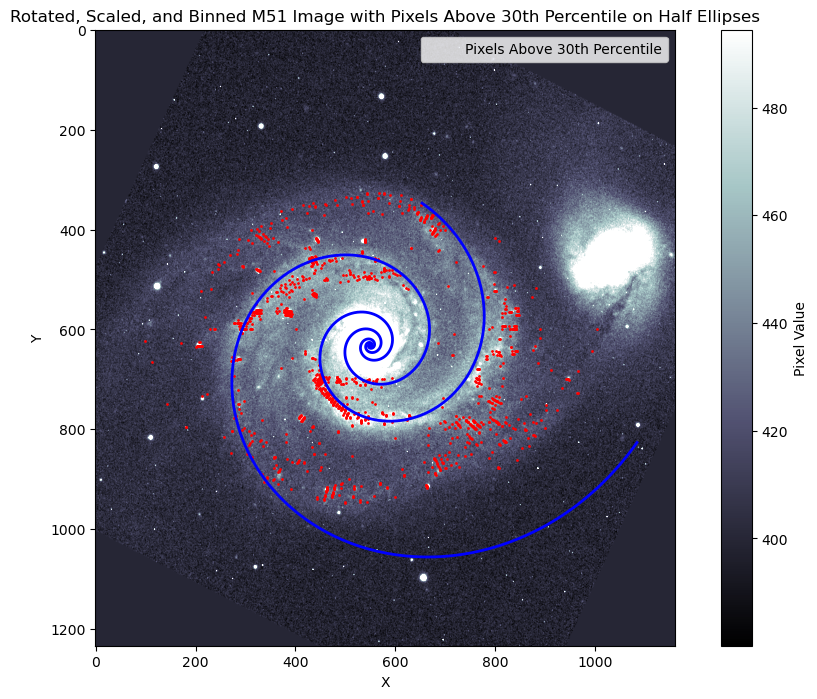

In [9]:
    # Z 스케일로 이미지의 최소 및 최대값 계산
    zscale = ZScaleInterval()
    vmin, vmax = zscale.get_limits(binned_image)

    # 중심 좌표를 바이닝 팩터로 나누어 조정
    xc_binned1, yc_binned1 = 550 // binning_factor, 600 // binning_factor

    # 반타원의 각도 설정
    theta_half1 = np.linspace(0, np.pi, 100)

    # 결과 이미지 표시
    plt.figure(figsize=(12, 8))
    plt.imshow(binned_image, cmap='bone', vmin=vmin, vmax=vmax)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.colorbar(label='Pixel Value')
    plt.title('Rotated, Scaled, and Binned M51 Image with Pixels Above 30th Percentile on Half Ellipses')

    # 반지름 범위 설정
    radius_ranges1 = [(100, 125), (125, 150), (150, 175), (175, 200), (200, 225), (225, 250), (250, 275), (275, 300), (300, 325), (325, 350)]

    for radius_range1 in radius_ranges1:
        min_radius1, max_radius1 = radius_range1
        radii1 = np.arange(min_radius1, max_radius1, 1)

        for radius1 in radii1:
            a = radius1 * 1.3  # 타원의 가로 반지름
            b = radius1  # 타원의 세로 반지름

            # 중심 좌표를 기준으로 반타원 위의 좌표 생성
            x_ellipse1 = xc_binned1 + a * np.cos(theta_half1)
            y_ellipse1 = yc_binned1 + b * np.sin(theta_half1)

            pixel_values1 = binned_image[np.round(y_ellipse1).astype(int), np.round(x_ellipse1).astype(int)]

            # 반타원 위의 픽셀 값 30번째 백분위수 계산
            percentile_301 = np.percentile(pixel_values1, 97)

            # 30번째 백분위수보다 큰 픽셀 좌표 선택
            above_30th_percentile1 = pixel_values1 > percentile_301
            x_above_301 = x_ellipse1[above_30th_percentile1]
            y_above_301 = y_ellipse1[above_30th_percentile1]

            # 반타원과 30번째 백분위수보다 큰 픽셀 표시
            plt.plot(x_ellipse1, y_ellipse1, 'b--', alpha=0)  # 반타원 표시
            plt.plot(x_above_301, y_above_301, 'ro', markersize=1)  # 30번째 백분위수보다 큰 픽셀 좌표 표시

    # Second set of data

    # 중심 좌표를 바이닝 팩터로 나누어 조정
    xc_binned, yc_binned = 550 // binning_factor, 600 // binning_factor

    # 반타원의 각도 설정
    theta_half = np.linspace(np.pi, 2 * np.pi, 100)

    # 반지름 범위 설정
    radius_ranges = [(100, 125), (125, 150), (150, 175), (175, 200), (200, 225), (225, 250), (250, 275), ]

    for radius_range in radius_ranges:
        min_radius, max_radius = radius_range
        radii = np.arange(min_radius, max_radius, 1)

        for radius in radii:
            a = radius *  1.3 # 타원의 가로 반지름
            b = radius  # 타원의 세로 반지름

            # 중심 좌표를 기준으로 반타원 위의 좌표 생성
            x_ellipse = xc_binned + a * np.cos(theta_half)
            y_ellipse = yc_binned + b * np.sin(theta_half)

            pixel_values = binned_image[np.round(y_ellipse).astype(int), np.round(x_ellipse).astype(int)]

            # 반타원 위의 픽셀 값 30번째 백분위수 계산
            percentile_30 = np.percentile(pixel_values, 97)

            # 30번째 백분위수보다 큰 픽셀 좌표 선택
            above_30th_percentile = pixel_values > percentile_30
            x_above_30 = x_ellipse[above_30th_percentile]
            y_above_30 = y_ellipse[above_30th_percentile]

            # 반타원과 30번째 백분위수보다 큰 픽셀 표시
            plt.plot(x_ellipse, y_ellipse, 'b--', alpha=0)# 반타원 표시
            plt.plot(x_above_30, y_above_30, 'ro', markersize=1)  # 97번째 백분위수보다 큰 픽셀 좌표 표시

    plt.legend([ 'Pixels Above 30th Percentile'])
    plt.plot(x_rotated1, y_rotated1, color='blue', linewidth=2)  # 첫 번째 회전된 나선 그리기
    plt.plot(x_rotated2, y_rotated2, color='blue', linewidth=2)  # 두 번째 회전된 나선 그리기
    plt.savefig('1_4.png')
    plt.show()

# 5x5 pixel spiral arm trackig method (Inappropriate)

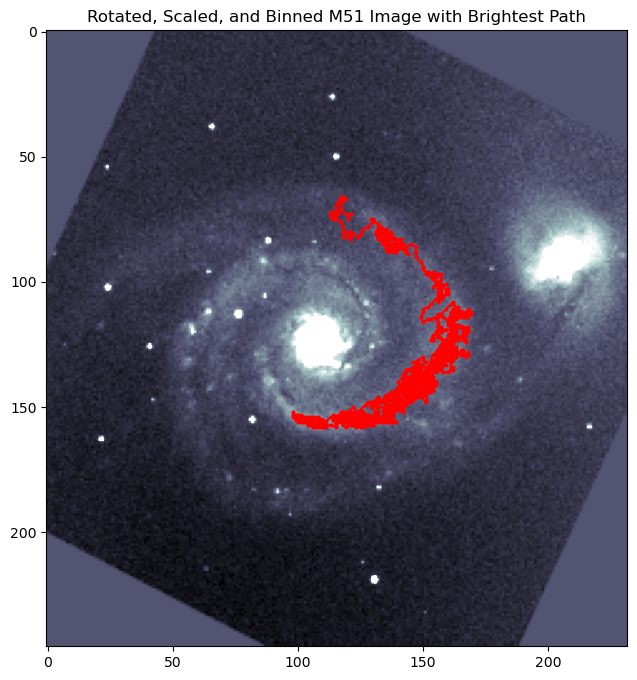

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from astropy.io import fits
from astropy.visualization import ZScaleInterval

# fits 파일 경로
fits_file_path =  r"C:/Users/User/AO1_JaehwanShin/00-preprocessing/My_Data/M51-0001r_new-image.fits"

# fits 파일 열기
with fits.open(fits_file_path) as hdul:
    # 이미지 데이터 가져오기
    image_data = hdul[0].data

    # 사용자가 입력한 좌표
    xc, yc = 612, 560  # 첫 번째 점의 좌표

    # 회전 각도
    angle = 154  # 회전 각도 (단위: 도)

    # 이미지를 중심으로 회전
    rotated_image = rotate(image_data, angle, reshape=False, order=1, mode='constant', cval=7700.0, prefilter=True)

    # 각도에 대한 삼각함수 값 계산 (20도)
    cos_angle_20 = np.cos(np.deg2rad(20))

    # 이미지의 높이를 삼각함수 값으로 나누어 조정
    scaled_height = int(rotated_image.shape[0] / cos_angle_20)

    # 이미지 크기 조정 (이전 높이를 기준으로 새로운 높이를 설정)
    scaled_image = np.full((scaled_height, rotated_image.shape[1]), 7700.0)  # 초기값을 7700으로 설정
    for i in range(rotated_image.shape[1]):
        scaled_image[:, i] = np.interp(np.linspace(0, rotated_image.shape[0] - 1, scaled_height),
                                       np.arange(rotated_image.shape[0]), rotated_image[:, i])

# 바이닝 크기 설정
bin_size = 5

# 바이닝 함수 정의
def bin_image(image, bin_size):
    # 이미지 크기를 bin_size로 나누어 떨어지도록 자름
    trimmed_image = image[:image.shape[0] // bin_size * bin_size,
                          :image.shape[1] // bin_size * bin_size]
    shape = (trimmed_image.shape[0] // bin_size, bin_size,
             trimmed_image.shape[1] // bin_size, bin_size)
    return trimmed_image.reshape(shape).mean(-1).mean(1)

# 이미지를 바이닝
binned_image = bin_image(scaled_image, bin_size)

# 특정 위치에서 시작하여 주변으로 이동하는 함수 정의
def follow_brightest_path(image, start_coord):
    path = [start_coord]
    visited = set(path)
    current_coord = start_coord
    
    while True:
        y, x = current_coord
        neighbors = [(y-2, x-2), (y-2, x-1), (y-2, x), (y-2, x+1), (y-2, x+2),
                     (y-1, x-2), (y-1, x-1), (y-1, x), (y-1, x+1), (y-1, x+2),
                     (y, x-2), (y, x-1), (y, x+1), (y, x+2),
                     (y+1, x-2), (y+1, x-1), (y+1, x), (y+1, x+1), (y+1, x+2),
                     (y+2, x-2), (y+2, x-1), (y+2, x), (y+2, x+1), (y+2, x+2)] # 24방향 이웃
        neighbors = [(ny, nx) for ny, nx in neighbors if 0 <= ny < image.shape[0] and 0 <= nx < image.shape[1]]
        neighbors = [coord for coord in neighbors if coord not in visited]
        
        if not neighbors:
            break
        
        # 가장 밝은 픽셀과 두 번째로 밝은 픽셀 찾기
        brightest = max(neighbors, key=lambda coord: image[coord])
        neighbors.remove(brightest)
        
        if neighbors:
            second_brightest = max(neighbors, key=lambda coord: image[coord])
            next_coord = second_brightest if brightest in visited else brightest
        else:
            next_coord = brightest
        
        path.append(next_coord)
        visited.add(next_coord)
        current_coord = next_coord
    
    return path

# 사용자 정의 시작 좌표 설정
start_coord = (75, 120)  # 예시 좌표, 사용자가 원하는 좌표로 설정

# 경로 찾기
path = follow_brightest_path(binned_image, start_coord)

# 경로에서 방문한 픽셀 좌표 출력
#for coord in path:
 #   print(f"Visited pixel at {coord} with value {binned_image[coord]}")

# Z 스케일로 이미지의 최소 및 최대값 계산
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(binned_image)
# 결과 이미지 표시
plt.figure(figsize=(8, 8))
plt.imshow(binned_image, cmap='bone', vmin=vmin, vmax=vmax)
path_y, path_x = zip(*path)
plt.plot(path_x, path_y, color='red', marker='o', markersize=2, linestyle='-')  # 경로 표시
plt.title('Rotated, Scaled, and Binned M51 Image with Brightest Path')
plt.savefig('2_1.png')
plt.show()


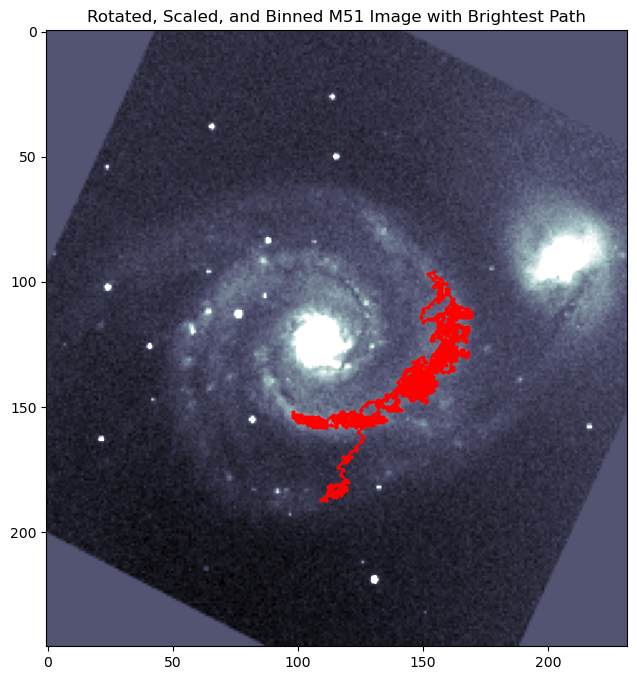

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from astropy.io import fits
from astropy.visualization import ZScaleInterval

# fits 파일 경로
fits_file_path =  r"C:/Users/User/AO1_JaehwanShin/00-preprocessing/My_Data/M51-0001r_new-image.fits"

# fits 파일 열기
with fits.open(fits_file_path) as hdul:
    # 이미지 데이터 가져오기
    image_data = hdul[0].data

    # 사용자가 입력한 좌표
    xc, yc = 612, 560  # 첫 번째 점의 좌표

    # 회전 각도
    angle = 154  # 회전 각도 (단위: 도)

    # 이미지를 중심으로 회전
    rotated_image = rotate(image_data, angle, reshape=False, order=1, mode='constant', cval=7700.0, prefilter=True)

    # 각도에 대한 삼각함수 값 계산 (20도)
    cos_angle_20 = np.cos(np.deg2rad(20))

    # 이미지의 높이를 삼각함수 값으로 나누어 조정
    scaled_height = int(rotated_image.shape[0] / cos_angle_20)

    # 이미지 크기 조정 (이전 높이를 기준으로 새로운 높이를 설정)
    scaled_image = np.full((scaled_height, rotated_image.shape[1]), 7700.0)  # 초기값을 7700으로 설정
    for i in range(rotated_image.shape[1]):
        scaled_image[:, i] = np.interp(np.linspace(0, rotated_image.shape[0] - 1, scaled_height),
                                       np.arange(rotated_image.shape[0]), rotated_image[:, i])

# 바이닝 크기 설정
bin_size = 5

# 바이닝 함수 정의
def bin_image(image, bin_size):
    # 이미지 크기를 bin_size로 나누어 떨어지도록 자름
    trimmed_image = image[:image.shape[0] // bin_size * bin_size,
                          :image.shape[1] // bin_size * bin_size]
    shape = (trimmed_image.shape[0] // bin_size, bin_size,
             trimmed_image.shape[1] // bin_size, bin_size)
    return trimmed_image.reshape(shape).mean(-1).mean(1)

# 이미지를 바이닝
binned_image = bin_image(scaled_image, bin_size)

# 특정 위치에서 시작하여 주변으로 이동하는 함수 정의
def follow_brightest_path(image, start_coord):
    path = [start_coord]
    visited = set(path)
    current_coord = start_coord
    
    while True:
        y, x = current_coord
        neighbors = [(y-2, x-2), (y-2, x-1), (y-2, x), (y-2, x+1), (y-2, x+2),
                     (y-1, x-2), (y-1, x-1), (y-1, x), (y-1, x+1), (y-1, x+2),
                     (y, x-2), (y, x-1), (y, x+1), (y, x+2),
                     (y+1, x-2), (y+1, x-1), (y+1, x), (y+1, x+1), (y+1, x+2),
                     (y+2, x-2), (y+2, x-1), (y+2, x), (y+2, x+1), (y+2, x+2)] # 24방향 이웃
        neighbors = [(ny, nx) for ny, nx in neighbors if 0 <= ny < image.shape[0] and 0 <= nx < image.shape[1]]
        neighbors = [coord for coord in neighbors if coord not in visited]
        
        if not neighbors:
            break
        
        # 가장 밝은 픽셀과 두 번째로 밝은 픽셀 찾기
        brightest = max(neighbors, key=lambda coord: image[coord])
        neighbors.remove(brightest)
        
        if neighbors:
            second_brightest = max(neighbors, key=lambda coord: image[coord])
            next_coord = second_brightest if brightest in visited else brightest
        else:
            next_coord = brightest
        
        path.append(next_coord)
        visited.add(next_coord)
        current_coord = next_coord
    
    return path

# 사용자 정의 시작 좌표 설정
start_coord = (180, 120)  # 예시 좌표, 사용자가 원하는 좌표로 설정

# 경로 찾기
path = follow_brightest_path(binned_image, start_coord)

# 경로에서 방문한 픽셀 좌표 출력
#for coord in path:
 #   print(f"Visited pixel at {coord} with value {binned_image[coord]}")

# Z 스케일로 이미지의 최소 및 최대값 계산
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(binned_image)
# 결과 이미지 표시
plt.figure(figsize=(8, 8))
plt.imshow(binned_image, cmap='bone', vmin=vmin, vmax=vmax)
path_y, path_x = zip(*path)
plt.plot(path_x, path_y, color='red', marker='o', markersize=2, linestyle='-')  # 경로 표시
plt.title('Rotated, Scaled, and Binned M51 Image with Brightest Path')
plt.savefig('2_2.png')
plt.show()
